<a href="https://colab.research.google.com/github/D3moSSS/AI/blob/main/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install pytesseract
!pip install pyspellchecker
!pip install azure.cognitiveservices.vision.computervision
!pip install dotenv
!pip install fuzzywuzzy
!pip install textdistance
!pip install pytesseract


In [44]:
!pip install language_tool_python

Text: Lucces in resolvarea
Locatia: [86.0, 314.0, 1335.0, 287.0, 1336.0, 443.0, 86.0, 478.0]
Text: TEMELOR la
Locatia: [140.0, 590.0, 1045.0, 587.0, 1046.0, 723.0, 140.0, 727.0]
Text: LABORA toarele de
Locatia: [81.0, 915.0, 1007.0, 926.0, 1004.0, 1039.0, 78.0, 1014.0]
Text: Inteligenta Artificialà!
Locatia: [108.0, 1129.0, 1450.0, 1151.0, 1446.0, 1293.0, 105.0, 1259.0]


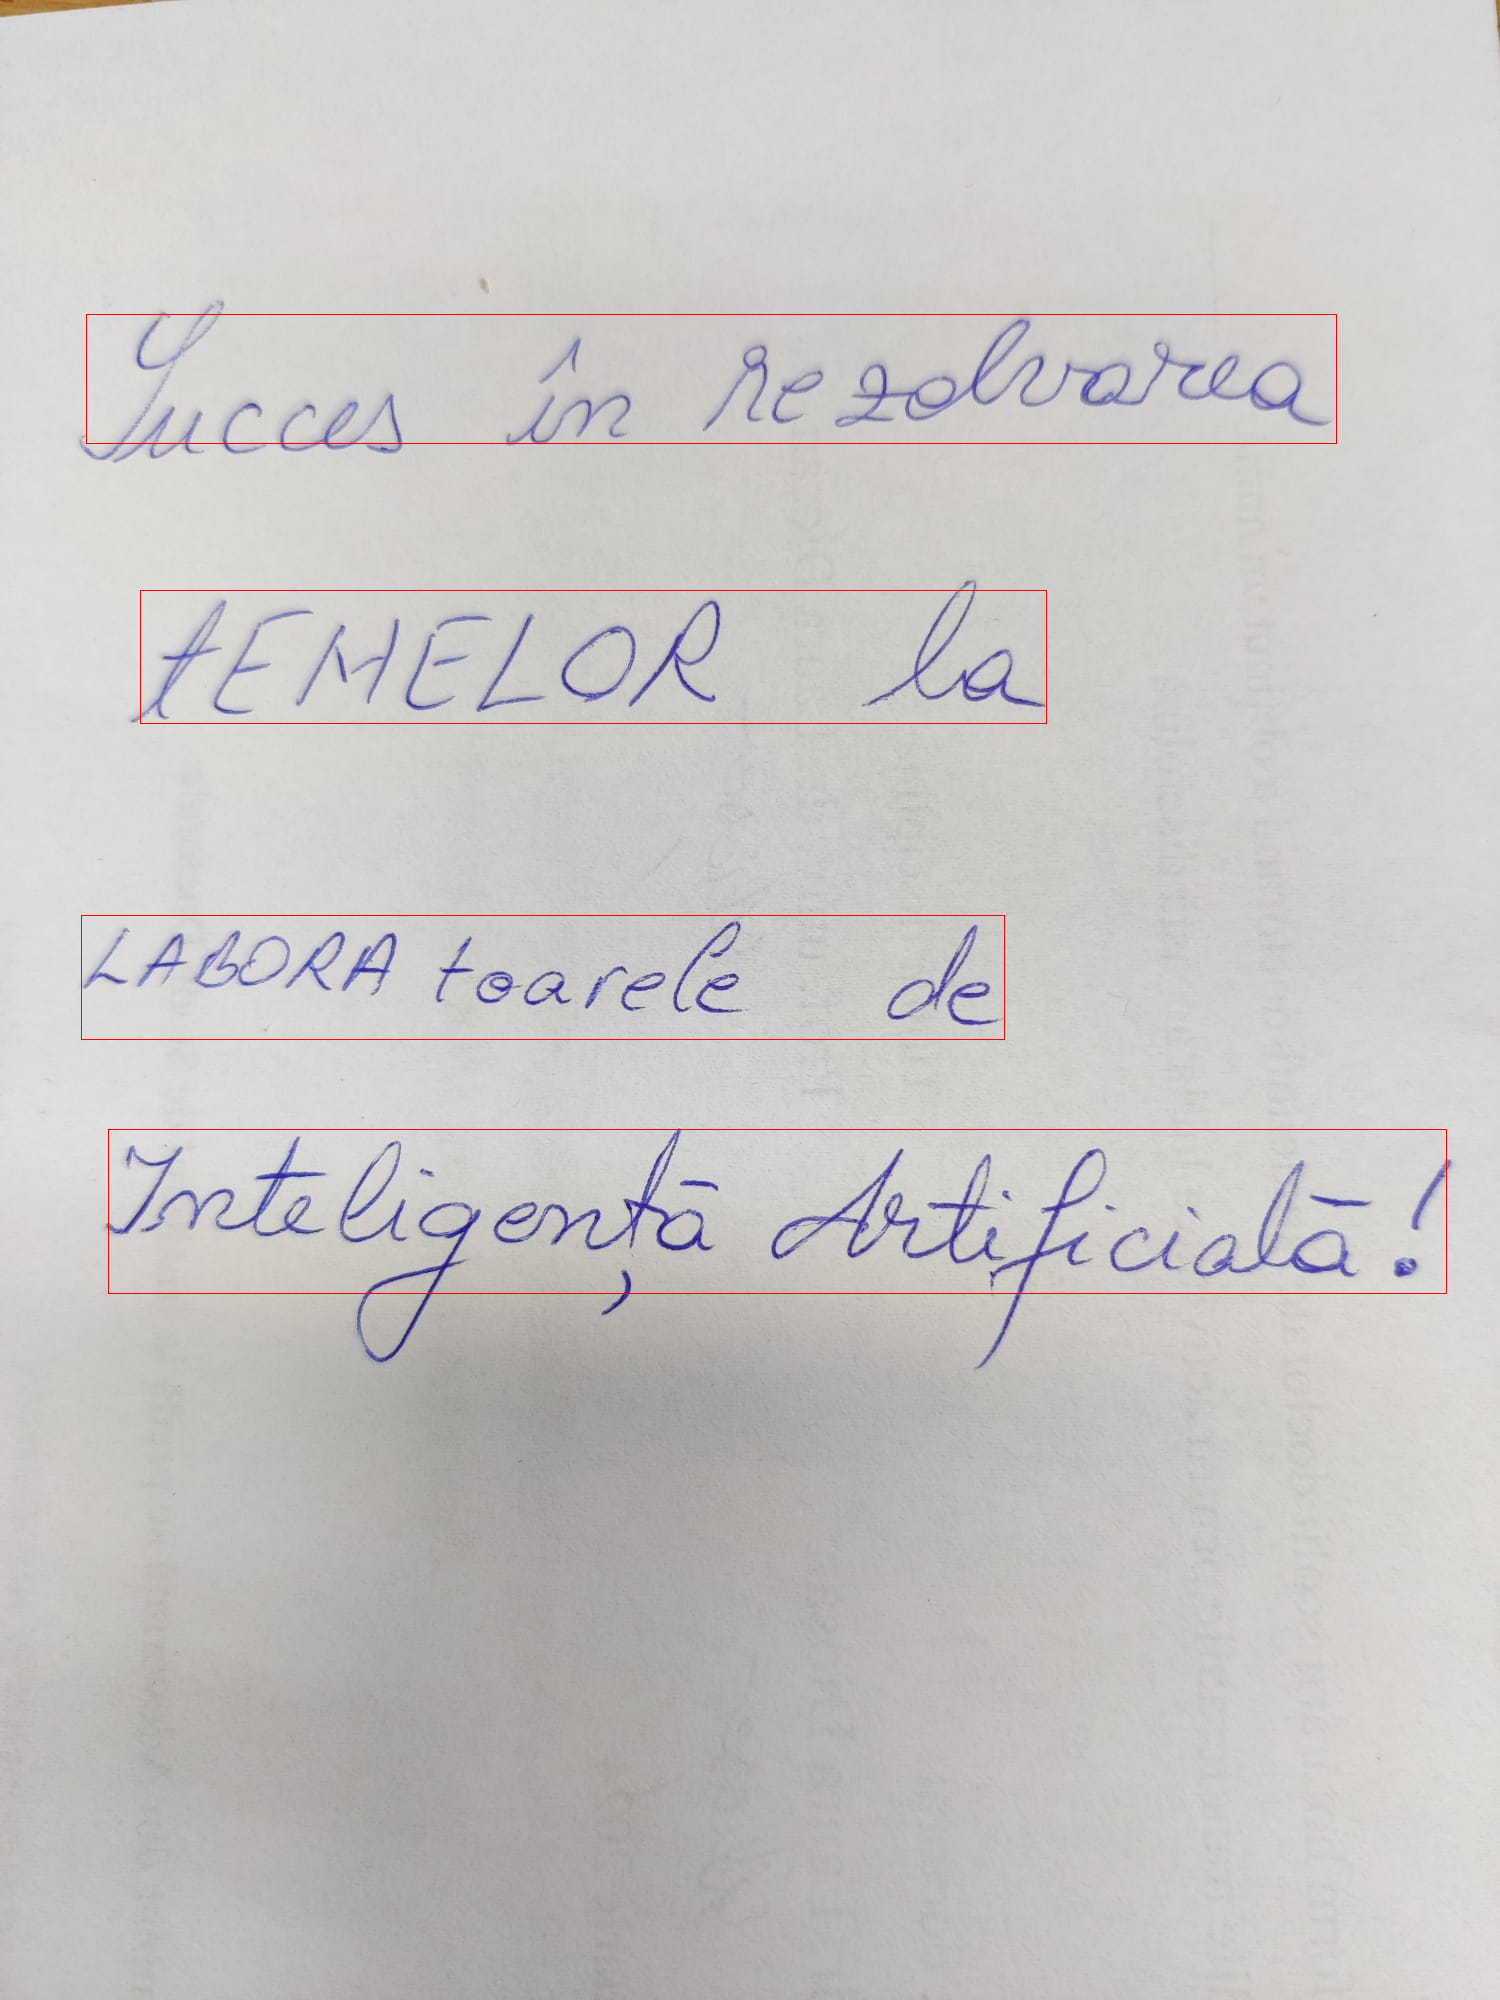


Textul recunoscut din imagine: Lucces in resolvarea TEMELOR la LABORA toarele de Inteligenta Artificialà! 
Distanta Levenstein: 9
Distanța Hamming: 40
jaccard_similarity: 0.11764705882352941
jaroWinklerDistance: 0.8524700697426111
Text: Lucces in resolvarea
Locatia: [86.0, 314.0, 1335.0, 287.0, 1336.0, 443.0, 86.0, 478.0]
Text: TEMELOR la
Locatia: [140.0, 590.0, 1045.0, 587.0, 1046.0, 723.0, 140.0, 727.0]
Text: LABORA toarele de
Locatia: [81.0, 915.0, 1007.0, 926.0, 1004.0, 1039.0, 78.0, 1014.0]
Text: Inteligenta Artificialà!
Locatia: [108.0, 1129.0, 1450.0, 1151.0, 1446.0, 1293.0, 105.0, 1259.0]


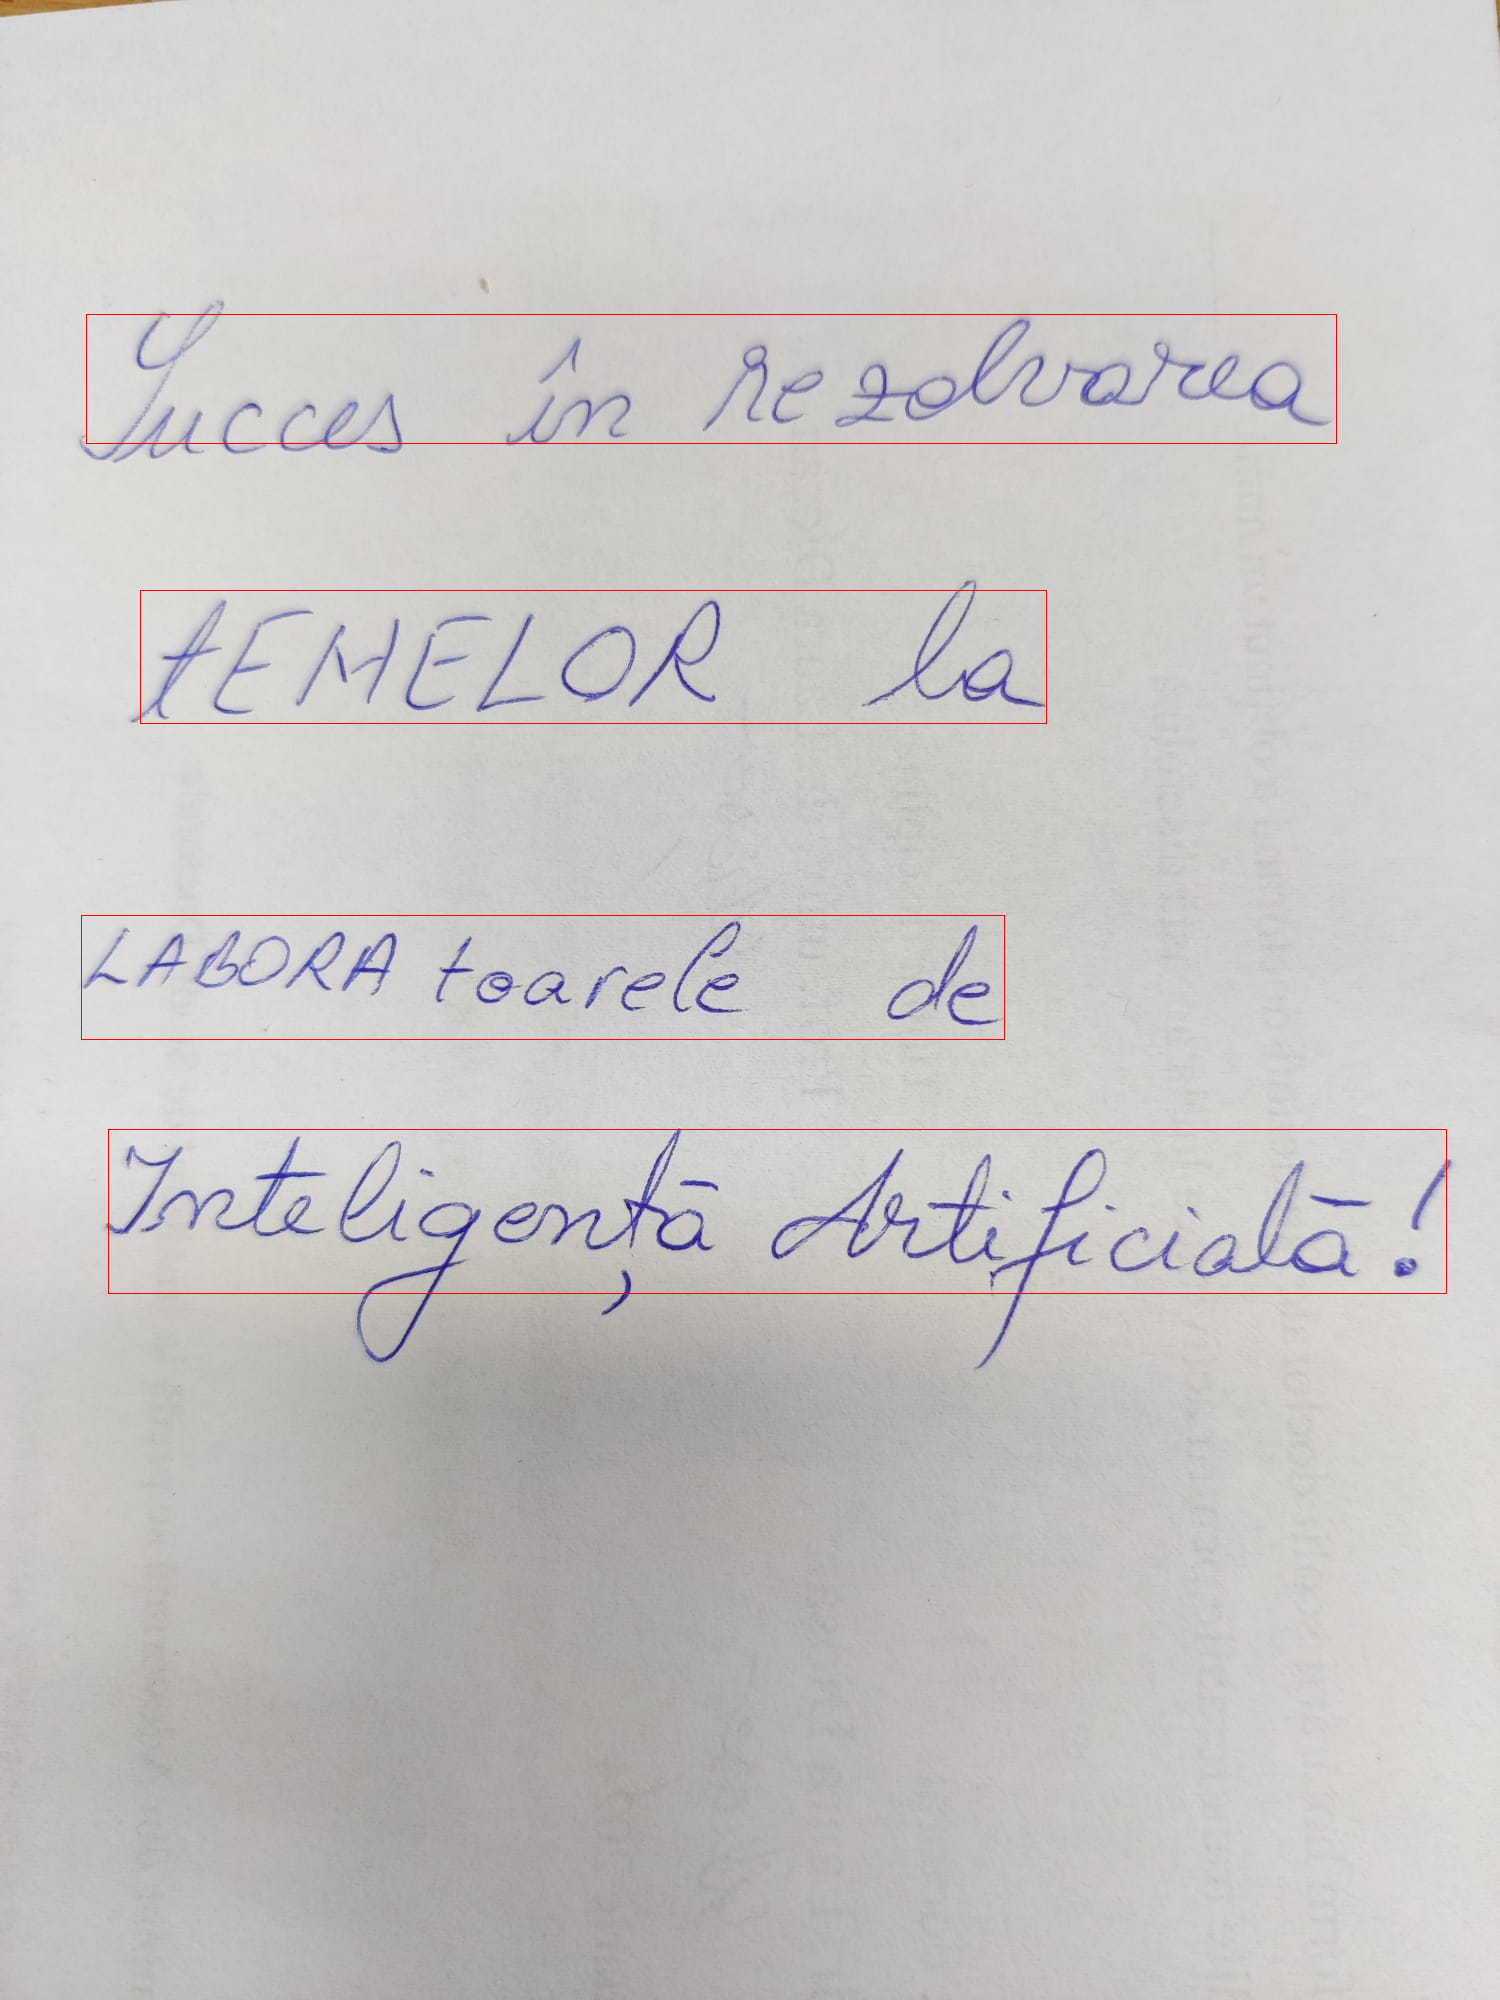

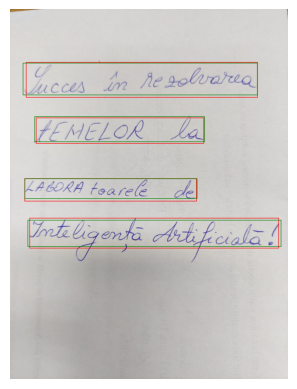

IoU: 0.899
IoU: 0.880
IoU: 0.876
IoU: 0.865
Text: Succes in resolvarea
Locatia: [77.0, 333.0, 1332.0, 305.0, 1334.0, 432.0, 79.0, 473.0]
Text: TEMELOR la
Locatia: [128.0, 586.0, 1045.0, 581.0, 1046.0, 720.0, 128.0, 726.0]
Text: LABORA toarele de
Locatia: [78.0, 914.0, 1002.0, 918.0, 1000.0, 1039.0, 75.0, 1017.0]
Text: Inteligenta Artificialà!
Locatia: [109.0, 1127.0, 1459.0, 1151.0, 1455.0, 1296.0, 106.0, 1262.0]


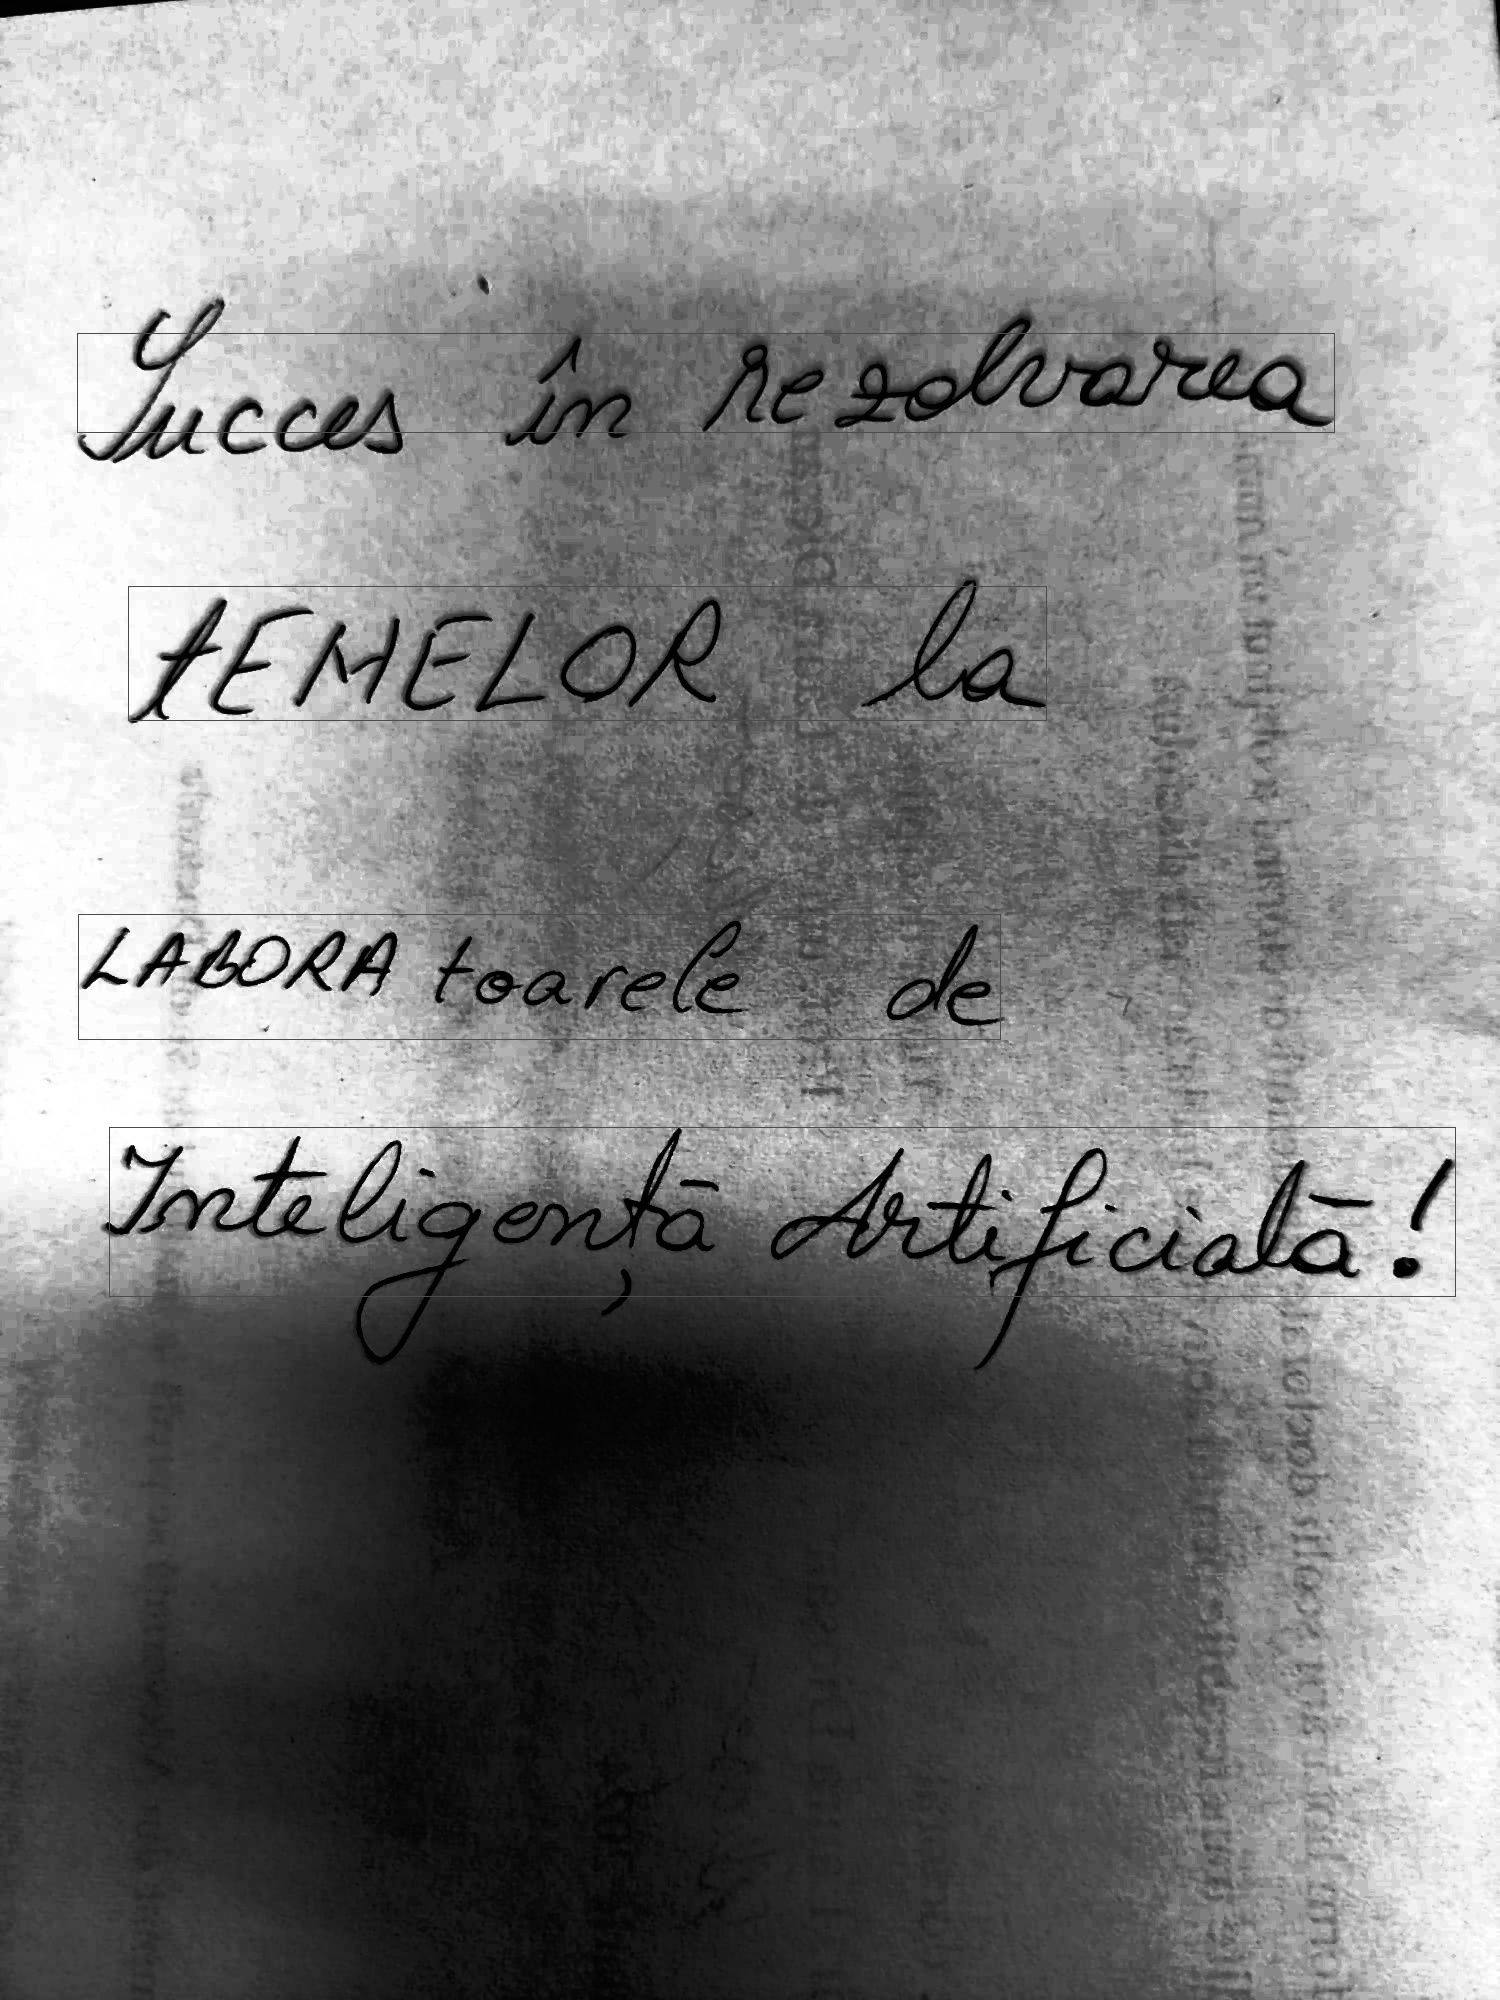

S u c c e s   i n   r e s o l v a r e a   T E M E L O R   l a   L A B O R A   t o a r e l e   d e   I n t e l i g e n t a   A r t i f i c i a l à !  
[[77.0, 333.0, 1332.0, 305.0, 1334.0, 432.0, 79.0, 473.0], [128.0, 586.0, 1045.0, 581.0, 1046.0, 720.0, 128.0, 726.0], [78.0, 914.0, 1002.0, 918.0, 1000.0, 1039.0, 75.0, 1017.0], [109.0, 1127.0, 1459.0, 1151.0, 1455.0, 1296.0, 106.0, 1262.0]]
IoU: 0.873
IoU: 0.930
IoU: 0.862
IoU: 0.844



Distanta Levenstein: 82
Distanța Hamming: 102
jaccard_similarity: 0.0
jaroWinklerDistance: 0.6349286938480349


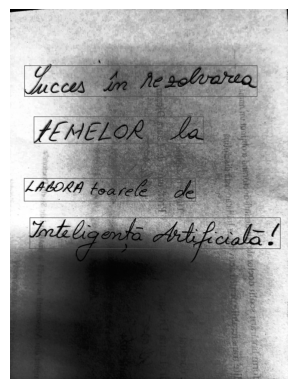

In [67]:
from spellchecker import SpellChecker
import cv2
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import ImageDraw , Image , ImageFilter, ImageEnhance
import sys
import time
from dotenv import load_dotenv
import numpy as np
from google.colab.patches import cv2_imshow
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import textdistance

'''Authenticates your credentials and creates a client.'''


def authenticate():
    load_dotenv("file.env")
    subscription_key = os.environ["VISION_KEY"]
    endpoint = os.environ["VISION_ENDPOINT"]
    credentials = CognitiveServicesCredentials(subscription_key)
    computervision_client = ComputerVisionClient(endpoint, credentials)
    return computervision_client


'''
    Calculează distanța Levenshtein între două șiruri de caractere.
    param s1: primul sir (string)
    param s2: al doilea sir (string)
    return: distanta Levenshtein (int) = numărul minim de operații necesare pentru a transforma un șir în altul

    Algoritmul funcționează pe baza unei matrice în care fiecare celulă reprezintă costul de transformare a unui prefix al primului șir într-un prefix al celui de-al doilea șir. Se parcurg caracterele ambelor șiruri și se calculează costurile de editare pentru fiecare pereche de caractere. Aceste costuri sunt memorate într-o matrice și sunt actualizate în timpul procesului de parcurgere.
    La final, se obține o matrice completă care conține toate costurile de editare pentru toate prefixele celor două șiruri. Distanța Levenshtein se găsește în ultima celulă a matricei și reprezintă costul minim de transformare a primului șir în al doilea.
'''


def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:  # Dacă al doilea șir este gol, distanța este lungimea primului șir
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


'''
    Calculează distanța Hamming între două șiruri de caractere.
    param s1: primul sir (string)
    param s2: al doilea sir (string)
    return: distanta Hamming (int) = numărul de poziții în care caracterele corespunzătoare din cele două șiruri sunt diferite.
'''


def hamming_distance(s1, s2):
    len_diff = abs(len(s1) - len(s2))
    if len(s1) < len(s2):
        s1 += ' ' * len_diff  # Completează s1 cu spații
    elif len(s2) < len(s1):
        s2 += ' ' * len_diff  # Completează s2 cu spații

    # Calculează distanța Hamming
    distance = sum(c1 != c2 for c1, c2 in zip(s1, s2))
    return distance


def jaccard_similarity(str1, str2):
    a = set(str1.split())
    b = set(str2.split())
    return len(a.intersection(b)) / len(a.union(b))

computervision_client = authenticate()

def jaroWinklerDistance(s: str, t: str) -> float:
  """Calculeaza distanta Jaro-Winkler intre doua siruri de caractere

  @Returns: distanta Jaro-Winkler
  """
  dist = textdistance.jaro_winkler(s, t)
  return dist

'''
#path = "test1.png"
#path = "ocr.png"
img = Image.open(path)
gray_img = img.convert('L')
blurred_img = gray_img.filter(ImageFilter.GaussianBlur(radius=1))
contrast_enhancer = ImageEnhance.Contrast(blurred_img)
contrast_enhanced_img = contrast_enhancer.enhance(2.0)
thresholded_img = contrast_enhanced_img.point(lambda p: 255 if p > 160 else 0)
'''

img = open("test2.jpeg", "rb")

#expected_text = "Google Cloud Platform"
#groundTruth = ["Google Cloud", "Platform"]

expected_text = "Succes în rezolvarea tEMELOR la LABORAtoarele de Inteligență Artificială!"
groundTruth = ["Succes în rezolvarea", "tEMELOR la", "LABORAtoarele de", "Inteligență Artificială!"]

# expected_text = "Optical Character Optical Character Recognition Recognition"
# groundTruth = ["Optical Character", "Optical Character", "Recognition", "Recognition"]
recognized_text = ""

'''citirea textului din imagine folosind serviciul Computer Vision'''
def read_img(img):
  read_response = computervision_client.read_in_stream(
      image=img,
      mode="Printed",
      raw=True
  )

  operation_id = read_response.headers['Operation-Location'].split('/')[-1]  # Obține ID-ul operației
  while True:
      read_result = computervision_client.get_read_result(operation_id)  # Obține rezultatul operației
      if read_result.status not in ['notStarted', 'running']:  # Operația a fost finalizată
          break
      time.sleep(1)

  recognized_text = ""
  bounding_boxes = []
  if read_result.status == OperationStatusCodes.succeeded:
      for text_result in read_result.analyze_result.read_results:
          for line in text_result.lines:
              print(f"Text: {line.text}")
              print(f"Locatia: {line.bounding_box}")
              recognized_text += line.text + " "
              bounding_boxes.append(line.bounding_box)

  if read_result.status == OperationStatusCodes.succeeded:
    with Image.open(img) as img:
        draw = ImageDraw.Draw(img)
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                left = line.bounding_box[0]
                top = line.bounding_box[1]
                right = line.bounding_box[4]
                bottom = line.bounding_box[5]
                draw.rectangle([left, top, right, bottom], outline="red")

        img_cv = np.array(img)
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

        cv2_imshow(img_cv)
        return recognized_text , bounding_boxes

  else:
      print("Text detection failed.")

recognized_text , read_result = read_img(img)

print()
print(f"Textul recunoscut din imagine: {recognized_text}")

'''1. calitatea procesului de recunoastere a textului.'''

levenstein_dist = levenshtein_distance(recognized_text, expected_text)
print(f"Distanta Levenstein: {levenstein_dist}")

hamming_dist = hamming_distance(recognized_text, expected_text)
print(f"Distanța Hamming: {hamming_dist}")

jaccard_similarity1 = jaccard_similarity(expected_text, recognized_text)
print(f"jaccard_similarity: {jaccard_similarity1}")

jaroWinklerDistance1 = jaroWinklerDistance(expected_text, recognized_text)
print(f"jaroWinklerDistance: {jaroWinklerDistance1}")


'''2 -------------------------------------------------------------------------------------------------------------------------------------------------------------- '''

def get_rect_from_points(points):
  """Creeaza un bounding box dintr-o lista de puncte

  @Returns: x_min, y_min, x_max, y_max
  """
  xs = [pt for pt in points[0::2]]
  ys = [pt for pt in points[1::2]]
  x_min, x_max = min(xs), max(xs)
  y_min, y_max = min(ys), max(ys)
  return (x_min, y_min, x_max, y_max)


# Acuratetea bboxurilor
def compute_iou(boxA, boxB):
  """Calculeaza IoU intre doua bounding boxuri

  @Returns: IoU
  """
  # boxA, boxB = (x1, y1, x2, y2)
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  inter_width = max(0, xB - xA)
  inter_height = max(0, yB - yA)
  inter_area = inter_width * inter_height

  areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
  areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
  union_area = areaA + areaB - inter_area

  iou = inter_area / union_area if union_area > 0 else 0
  return iou


bbexpected = [[69,295,1335,291,69,465,1335,465],[132,580,1050,580,132,715,1050,718],[79,917,1007,916,80,1025,1010,1024],[95,1140,1459,1144,95,1284,1463,1281]]


img_2 = open("test2.jpeg" , "rb")
img_tst2 = Image.open("test2.jpeg")
draw = ImageDraw.Draw(img_tst2)

extracted_text, _boxes = read_img(img_2)

# Desenează bounding boxes și textul
for bbox in _boxes:
    xmin, ymin, xmax, ymax = get_rect_from_points(bbox)
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)

for bbx in bbexpected:
  xmin, ymin, xmax, ymax = get_rect_from_points(bbx)
  draw.rectangle([xmin, ymin, xmax, ymax], outline="green", width=3)

plt.imshow(img_tst2)
plt.axis('off')
plt.show()


for det, gt in zip(_boxes, bbexpected):
  box_det = get_rect_from_points(det)
  box_gt = get_rect_from_points(gt)
  iou = compute_iou(box_det, box_gt)
  print(f"IoU: {iou:.3f}")


''' 3 -------------------------------------------------------------------------------------------------------------------------------------------------------------- '''

import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from azure.core.credentials import AzureKeyCredential
from google.colab.patches import cv2_imshow

def preprocess_image(img_path):
  """Preprocesare imagine: contrast, binarizare, reductie zgomot

  @Returns: imaginea procesata
  """
  img = cv2.imread(img_path)


  # Conversia la alb-negru (Binarizare)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Reducerea zgomotului
  img_a = cv2.equalizeHist(img_gray)
  img_bin = cv2.medianBlur(img_a, 3)


  processed_img_path = "processed_image.jpg"
  cv2.imwrite(processed_img_path, img_bin)

  return processed_img_path

def draw_bbox(img_path, bbox_data):
  """Deseneaza bounding boxuri pe imaginea initiala

  @Returns: imaginea cu bounding boxuri
  """
  img = Image.open(img_path)
  draw = ImageDraw.Draw(img)

  for bbox in bbox_data:
    x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

  output_img_path = "output_with_bboxes.jpg"
  img.save(output_img_path)

  return output_img_path


def process_image(img_path):
  """Proceseaza imaginea

  @Returns: imaginea procesata, bounding boxurile, textul detectat
  """
  processed_img_path = preprocess_image(img_path)
  img_2 = open("processed_image.jpg", "rb")
  extracted_text, bbox_data = read_img(img_2)

  bxes = []
  for bbox in bbox_data:
    bxes.append(get_rect_from_points(bbox))

  output_img_path = draw_bbox(processed_img_path, bxes)

  print(" ".join(extracted_text))
  print(bbox_data)

  return output_img_path, bbox_data, extracted_text

def spellcheck(text):
  """Spellcheck pe text

  @Returns: textul spellchecked
  """
  spell = spellchecker.SpellChecker()
  words = text.split()
  corrected_words = []
  for word in words:
      corrected_word = spell.correction(word)

  return corrected_words

img_path = "test2.jpeg"

output_image, bboxes, extracted_text = process_image(img_path)

result_text = " ".join(extracted_text)

for det, gt in zip(bboxes, bbexpected):
  box_det = get_rect_from_points(det)
  box_gt = get_rect_from_points(gt)
  iou = compute_iou(box_det, box_gt)
  print(f"IoU: {iou:.3f}")

print("\n\n")


levenstein_dist = levenshtein_distance(result_text, expected_text)
print(f"Distanta Levenstein: {levenstein_dist}")

hamming_dist = hamming_distance(result_text, expected_text)
print(f"Distanța Hamming: {hamming_dist}")

jaccard_sim  = jaccard_similarity(result_text, expected_text)
print(f"jaccard_similarity: {jaccard_sim }")

jaroWinklerDis = jaroWinklerDistance(result_text, expected_text)
print(f"jaroWinklerDistance: {jaroWinklerDis}")


image = cv2.imread(output_image)
plt.imshow(image)
plt.axis('off')
plt.show()
